In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import scipy.stats as stats

### ЗАгрузка датасета

In [2]:
events = pd.read_excel('events_.xlsx')
events['event_dt'] = pd.to_datetime(events['event_dt']).dt.date # выбираю только даты 
events.head()

,user_id,event_name,event_dt,acq_channel
0,--0-b0cbb8-a,first_game,2020-06-08,GameAds
1,--0-b0cbb8-a,first_upgrade,2020-06-09,GameAds
2,--0-b0cbb8-a,login,2020-06-01,GameAds
3,--0-b0cbb8-a,registration,2020-06-01,GameAds
4,--0-b0cbb8-a,tutorial_completed,2020-06-08,GameAds


acq_channel,BrainPlus,GameAds,JetAds,SenseAds
event_name,,,,
login,100.00%,100.00%,100.00%,100.00%
registration,94.53%,97.44%,98.35%,99.16%
tuturial_started,84.97%,93.95%,95.32%,98.00%
tutorial_completed,64.23%,76.86%,85.82%,91.45%
first_game,46.73%,63.82%,75.83%,85.71%
first_upgrade,10.71%,33.51%,26.64%,60.49%
purchase,0.96%,1.85%,3.06%,4.14%
friend_invite,0.16%,1.53%,0.63%,4.88%


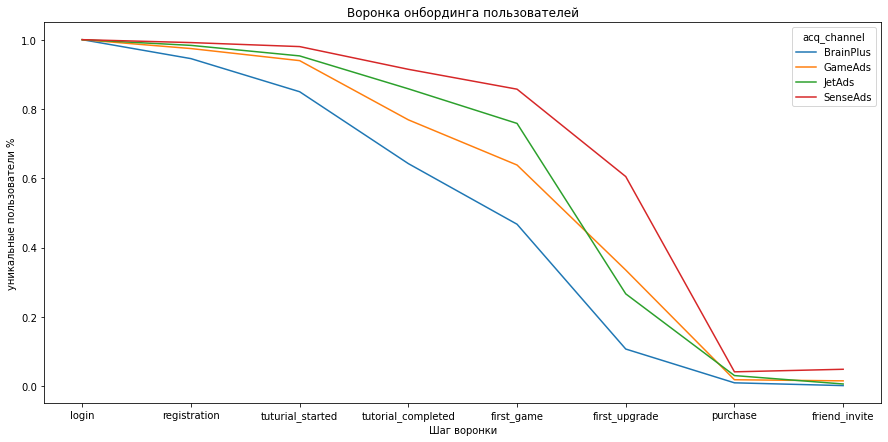

In [3]:
pivot_events = events.pivot_table(index='event_name', columns = 'acq_channel', values = 'user_id', aggfunc = 'nunique').fillna(0)
pivot_events = pivot_events.sort_values('BrainPlus', ascending = False)
for col in pivot_events.columns:
    pivot_events[col] = pivot_events[col] / pivot_events.loc['login', col] # конверсия 

pivot_events.plot(figsize=(15,7))
plt.title('Воронка онбординга пользователей'), plt.xlabel('Шаг воронки'), plt.ylabel('уникальные пользователи %')

pivot_events.style.format('{:.2%}')

In [4]:
purchases = pd.read_excel('purchases_.xlsx')
purchases.head()

,user_id,event_dt,revenue,ad_network
0,fb1b6f9ddc3ddd6d,2021-02-01 10:26:57,4.99,FB
1,fb1b6f9ddc3ddd6d,2021-02-06 22:15:05,4.99,FB
2,fb1b6f9ddc3ddd6d,2021-02-19 04:36:59,4.99,FB
3,fb1b6f9ddc3ddd6d,2021-02-26 21:14:23,4.99,FB
4,fb1b6f9ddc3ddd6d,2021-03-04 21:03:59,4.99,FB


### z_test одновыборочный
С помощью одновыборочного z-теста для пропорций проверьте гипотезу о том, что доля пользователей из источника BrainPlus, игравших первую самостоятельную битву (т.е. выполнивших шаг first_game) равна 50%:

In [5]:
from statsmodels.stats.proportion import proportions_ztest

# задаем уровень значимости
alpha = 0.05

# задаем порог , нулевая гипотеза гласит,что доля пользователей игравших первую самостоятельную игру равна 50%,
# а альтернативная гипотеза гласит, что доля не равна
value = 0.5

# подготовка данных
pivot_events = events.pivot_table(index='event_name', columns = 'acq_channel', values = 'user_id', aggfunc = 'nunique')
pivot_events = pivot_events.sort_values(by='BrainPlus', ascending = False)

print('Пользователи из источника BrainPlus закончившие первую игру: {}, общее кол-во пользователей: {}, конверсия: {}'.format(
    pivot_events.loc['first_game', 'BrainPlus'], pivot_events.loc['login', 'BrainPlus'], 
    pivot_events.loc['first_game', 'BrainPlus'] / pivot_events.loc['login', 'BrainPlus']))
# проводим тест
p_value = proportions_ztest(pivot_events.loc['first_game', 'BrainPlus'], pivot_events.loc['login', 'BrainPlus'], value = value)[1]
print('p_value: {:.5f}'.format(p_value))

# анализируем результат
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: доля целевых наблюдений не равна заданному порогу.')
else:
    print('Не отвергаем нулевую гипотезу: доля целевых наблюжений равна заданному порогу.')

Пользователи из источника BrainPlus закончившие первую игру: 21700, общее кол-во пользователей: 46433, конверсия: 0.467340038334805
p_value: 0.00000
Отвергаем нулевую гипотезу: доля целевых наблюдений не равна заданному порогу.


### z_test двухвыборочный
С помощью двухвыборочного z-теста для пропорций проверьте гипотезу о том, что доли пользователей, игравших первую самостоятельную битву, равны для пользователей из источников BrainPlus и SenseAds:

In [6]:
# подготовка данных
first_gamers_brain = pivot_events.loc['first_game', 'BrainPlus']
all_login_brain = pivot_events.loc['login', 'BrainPlus']

first_gamers_sense = pivot_events.loc['first_game', 'SenseAds']
all_login_sense = pivot_events.loc['login', 'SenseAds']

print('BrainPlus gamers: {}, общее число игроков: {}, конверсия: {}'.format(first_gamers_brain, all_login_brain,
                                                                            first_gamers_brain / all_login_brain ))
print('SenseAds gamers: {}, общее число игроков: {}, конверсия: {}'.format(first_gamers_sense, all_login_sense,
                                                                            first_gamers_sense / all_login_sense ))
# уровень значимости
alpha = 0.05

# гипотезы
# Конверсии пользователей игравших первую игру с каналы BrainPlus равны пользователям с канала SenseAds. Так звучит нулевая гипотеза 
# Альтернативная говорит же, что конверсии не равны

# проволим тест
p_value = proportions_ztest([first_gamers_brain, first_gamers_sense], [all_login_brain, all_login_sense])[1]
print('p_value: {:.5f}'.format(p_value))

# анализируем результат
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: доли целевых наблюдений в двух группах отличаются')
else:
    print('Не отвергаем нулевую гипотезу: доли целевых наблюдений в обеих группах совпадают')

BrainPlus gamers: 21700, общее число игроков: 46433, конверсия: 0.467340038334805
SenseAds gamers: 4289, общее число игроков: 5004, конверсия: 0.8571143085531575
p_value: 0.00000
Отвергаем нулевую гипотезу: доли целевых наблюдений в двух группах отличаются


In [7]:
report = events.query('acq_channel == "BrainPlus"').groupby('event_name').agg({'user_id':['count','nunique']})
report.columns = ['События','Уникальные пользователи']
report = report.sort_values(by = 'Уникальные пользователи',ascending = False)
report['%'] = report['Уникальные пользователи'] / report['Уникальные пользователи'].values[0]
report.style.format({'%':'{:.2%}'})

,События,Уникальные пользователи,%
event_name,,,
login,46433,46433,100.00%
registration,43893,43893,94.53%
tuturial_started,39456,39456,84.97%
tutorial_completed,29823,29823,64.23%
first_game,21700,21700,46.73%
first_upgrade,4975,4975,10.71%
purchase,1914,448,0.96%
friend_invite,76,76,0.16%


### t-тест
Один из ваших коллег выдвинул гипотезу о том, что среднее число покупок, совершенных пользователями, привлеченными из источников GameAds и JetAds равны. Проверьте эту гипотезу с помощью двухвыборочного t-теста:

In [8]:
purchases = pd.read_excel('purchases_.xlsx')
purchases['event_dt'] = pd.to_datetime(purchases['event_dt']).dt.date
purchases

,user_id,event_dt,revenue,ad_network
0,fb1b6f9ddc3ddd6d,2021-02-01,4.99,FB
1,fb1b6f9ddc3ddd6d,2021-02-06,4.99,FB
2,fb1b6f9ddc3ddd6d,2021-02-19,4.99,FB
3,fb1b6f9ddc3ddd6d,2021-02-26,4.99,FB
4,fb1b6f9ddc3ddd6d,2021-03-04,4.99,FB
...,...,...,...,...
18227,41a6960b610cd152,2021-06-08,4.99,Instagroom
18228,33927ac261f94ba5,2021-06-08,4.99,Instagroom
18229,7d3453c718fb492d,2021-06-12,4.99,Instagroom
18230,7d3453c718fb492d,2021-06-18,4.99,Instagroom


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


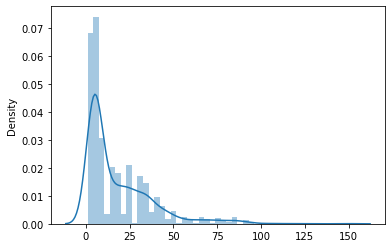

In [9]:
purchases_inst = purchases.query('ad_network == "Instagroom"').groupby('user_id').agg({'revenue' : ['count', 'sum']})
ax = sns.distplot(purchases_inst, label = 'Средний чек')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Среднее кол-во покупок FB: 5.50
Среднее кол-во покупок Instagroom: 5.08
p-value: 0.00000
Отвергаем нулевую гипотезу: средние покупки в двух группах не равны


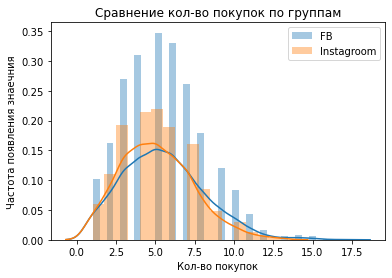

In [10]:
# подготовка данных
purchases_report = purchases.groupby('user_id').agg({'ad_network': 'first', 'revenue': 'count'})
for itm in purchases_report['ad_network'].unique():
    current = purchases_report.query('ad_network == @itm')['revenue']
    sns.distplot(current, label = itm)
    print('Среднее кол-во покупок {}: {:.2f}'.format(itm, current.mean()))
plt.legend(), plt.xlabel('Кол-во покупок'), plt.ylabel('Частота появления знаечния'), 
plt.title('Сравнение кол-во покупок по группам')

report_inst = purchases_report.query('ad_network == "FB"')['revenue']
report_FB = purchases_report.query('ad_network == "Instagroom"')['revenue']

# уровень значимости
alpha = 0.05

# проводим тест
p_value = stats.ttest_ind(report_inst, report_FB, equal_var = False).pvalue
print('p-value: {:.5f}'.format(p_value))

# анализируем результат
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: средние покупки в двух группах не равны')
else:
    print('Не отвергаем нулевую гипотезу: средние покупки в двух группах равны')

Результаты теста показывают, что среднее кол-во покупок для данных каналов не равны, кол-во покупок с канала FB больше на 0.4. Длинный хвост показывает выбросы.

In [11]:
purchases_report

,ad_network,revenue
user_id,,
0026a8f0dc63d2f9,FB,9
0031622f6c255f06,Instagroom,9
004d717fa0b99cdb,Instagroom,3
0051725df72fadd4,FB,5
0075709c27879d34,FB,2
...,...,...
ffb9c92a60086724,FB,7
ffc9f339cc3b3fa4,FB,7
ffdbc58b0651248b,Instagroom,3


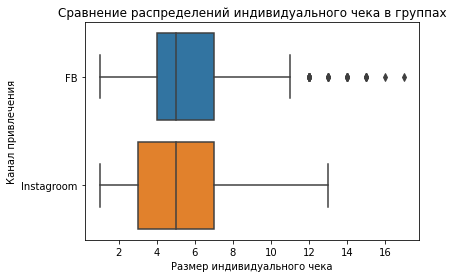

In [12]:
sns.boxplot(data = purchases_report, x = 'revenue', y = 'ad_network')
plt.xlabel('Размер индивидуального чека'), plt.ylabel('Канал привлечения'),
plt.title('Сравнение распределений индивидуального чека в группах');

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Среднее кол-во покупок FB: 5.06
Среднее кол-во покупок Instagroom: 4.68
p-value: 0.00000
Отвергаем нулевую гипотезу: средние покупки в двух группах не равны


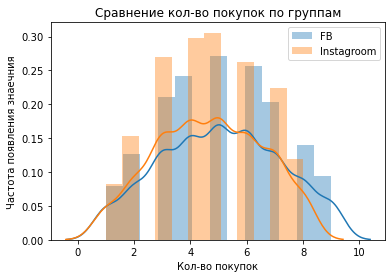

In [13]:
# предел выбросов 
outlier_limit = 0.95

# готовим данные
purchases_report = purchases.groupby('user_id').agg({'ad_network': 'first', 'revenue': 'count'})
for itm in purchases_report['ad_network'].unique():
    current = purchases_report.query('ad_network == @itm')['revenue']
    current = current[current < current.quantile(outlier_limit)] # исключаем выбросы
    sns.distplot(current, label = itm)
    print('Среднее кол-во покупок {}: {:.2f}'.format(itm, current.mean()))
plt.legend(), plt.xlabel('Кол-во покупок'), plt.ylabel('Частота появления знаечния'), 
plt.title('Сравнение кол-во покупок по группам')

report_inst = purchases_report.query('ad_network == "FB"')['revenue']
report_inst = report_inst[report_inst < report_inst.quantile(outlier_limit)] # исключаем выбросы

report_FB = purchases_report.query('ad_network == "Instagroom"')['revenue']
report_FB = report_FB[report_FB < report_FB.quantile(outlier_limit)] # исключаем выбросы

# уровень значимости
alpha = 0.05

# проводим тест
p_value = stats.ttest_ind(report_inst, report_FB, equal_var = False).pvalue
print(f'p-value: {p_value:.5f}')

# анализируем результат 
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: средние покупки в двух группах не равны')
else:
    print('Не отвергаем нулевую гипотезу: средние покупки в двух группах равны')

Результаты теста показывают, что среднее кол-во покупок для данных каналов не равны, кол-во покупок с канала FB больше также на 0.4. Убрал выбросы, хвосты ушли, что привело к коррекции средних значений. Но на общий рузультат теста это не повлияло.

### Тест Манна-Уитни

Возьмите задачу из задания 3 и проверьте гипотезу с помощью теста Манна-Уитни. Используйте не очищенные данные (с выбросами).

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Среднее кол-во покупок FB: 5.50
Среднее кол-во покупок Instagroom: 5.08
p-value: 0.00003
Отвергаем нулевую гипотезу: Средние из двух выборок не равны


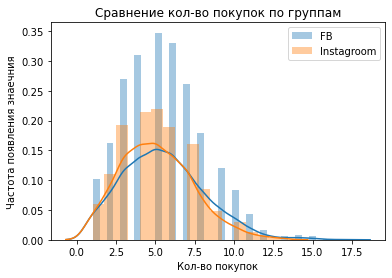

In [14]:
# гипотезы
Н0 = 'Средние из двух выборок равны'
Н1 = 'Средние из двух выборок не равны'

# урвоень значимости
alpha = 0.05

# подготовка данных
purchases_report = purchases.groupby('user_id').agg({'ad_network': 'first', 'revenue': 'count'})
for itm in purchases_report['ad_network'].unique():
    current = purchases_report.query('ad_network == @itm')['revenue']
    sns.distplot(current, label = itm)
    print('Среднее кол-во покупок {}: {:.2f}'.format(itm, current.mean()))
plt.legend(), plt.xlabel('Кол-во покупок'), plt.ylabel('Частота появления знаечния'), 
plt.title('Сравнение кол-во покупок по группам')

report_inst = purchases_report.query('ad_network == "FB"')['revenue']
report_FB = purchases_report.query('ad_network == "Instagroom"')['revenue']

# проводим тест
p_value = stats.mannwhitneyu(report_inst, report_FB, alternative = 'two-sided').pvalue
print(f'p-value: {p_value:.5f}')

# Аналализ результата
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: Средние из двух выборок не равны')
else:
    print('Не отвергаем нулевую гипотезу: Средние из двух выборок равны')

Тест Манна-Уитни больше похож на двустороний t-тест, в даннам тесте не нужно удалять выбросы